# 微分方程
定义：方程中未知量为函数，其中还涉及到未知函数的导数。

### 可分离变量的一阶微分方程
形如：$g(y)dy=f(x)dx$，变量处于等号两端，两端积分。

### 齐次方程
形如：$\frac{dy}{dx}=f(\frac{y}{x})$

### 可齐次方程
形如：$\frac{dY}{dX}=\frac{aX+bY+c}{cX+dY+m}(\frac{a}{c} \neq \frac{b}{d})$

# Python 求解微分方程



In [121]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import sympy
from scipy import integrate

In [122]:
# Initialize the screen
sympy.init_printing()

##### 牛顿冷却定律
$\frac{dT(t)}{dt} = -k(T(t) - H)$
T(t)：当前物体温度
H：周围温度
k：比例系数

In [123]:
t, k, H, t0 = sympy.symbols('t,k,H,t0')
T = sympy.Function('T')

In [124]:
ode = T(t).diff(t) + k * (T(t) - H)

In [125]:
sympy.Eq(ode, 0)

In [126]:
ode_sol = sympy.dsolve(ode)
print(ode_sol)

Eq(T(t), C1*exp(-k*t) + H)


In [127]:
ics = {T(0): t0}
c_eq = sympy.Eq(ode_sol.lhs.subs(t, 0).subs(ics), ode_sol.rhs.subs(t, 0))
c_eq

In [128]:
c_sol = sympy.solve(c_eq)
c_sol

In [129]:
ode_sol = ode_sol.subs(c_sol[0])
ode_sol

In [130]:
ode_sol.free_symbols

In [131]:
# 例题：y'' + 2*y' + 2*y = 0;   y(0) = 0, y'(0) = 1
x = sympy.symbols('x')
y = sympy.Function('y')(x)
ode_1 = sympy.Eq(y.diff(x, 2) + 2 * y.diff(x) + 2 * y, 0)
con = {y.subs(x, 0): 0, y.diff(x).subs(x, 0): 1}
ode_sol = sympy.dsolve(ode_1, ics=con)
ode_sol

### 微分方程的数值解
从数值计算角度来说，数值方法关心的是区域内的每个采样点处的函数值，如果直接对式子进行赋值运算将得到每个采样点出的斜率值。

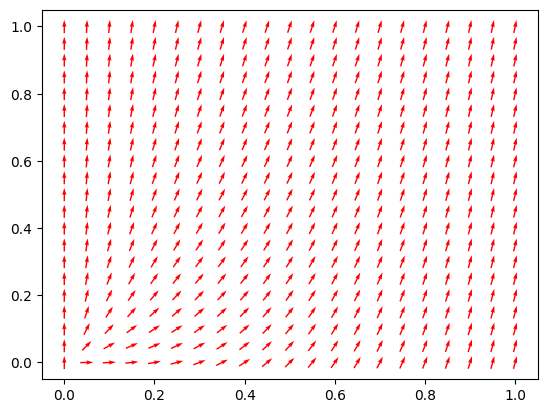

In [132]:
# ode: y' = xy + x ** 4; 显示斜率场
x = np.linspace(0, 1, 21)
y = np.linspace(0, 1, 21)
xx, yy = np.meshgrid(x, y)
dy = xx * yy + xx ** 4
E_x, E_y = np.gradient(dy)
E_norm = np.hypot(E_x, E_y)

fig, ax = plt.subplots()
ax.quiver(xx, yy, E_x/E_norm, E_y/E_norm, color='red', pivot='mid')
fig.savefig('./imgs/slope.png', dpi=600)
plt.show()

In [133]:
step = 0.1
sampling_points = np.arange(0, 1 + step, step)
sampling_res = np.zeros(sampling_points.shape[0])
sampling_res[0] = 0.37
for i in np.arange(sampling_res.shape[0] - 1):
    slop = sampling_points[i] * sampling_res[i] + sampling_points[i] ** 4
    sampling_res[i + 1] = sampling_res[i] + slop * step

ax.plot(sampling_points, sampling_res, color='blue', label='euler')
ax.scatter(sampling_points, sampling_res, color='red')
ax.legend()
fig.savefig('./imgs/slope_euler.png')

##### 欧拉法误差分析
使用泰勒公式进行展开：
$y_{n+1} = y(x_i) + y'(x_i)*h + \frac{y''(x_i)}{2} * h**2 + O(h**3)\\$
截断误差为 $R_{i+1} = O(h**2)\\$
对于某算法的局部截断误差为 $O(h_{p+1})$，则称该算法有 p 阶精度 
> h 取值越小，误差越小

### 龙格-库塔法
欧拉方法存在精度的问题，欧拉方法是单步迭代，只使用了前一个点的信息。如果使用多个数据点进行计算，使误差多项式的阶数提高。
递推公式：$$ \begin{cases}
y_{n+1} = y_n + a_1 * k_1 + a_2 * k_2\\
k_1 = h * f(x_n, y_n)\\
k_2 = h * f(x_n + b * n, y_n + c*k_1) & 0 < b, c < 1
\end{cases} $$

> k1, k2 为两个不同点处的增量，下一个值的增量部分为两个增量的加权平均

泰勒展开式：$y_{n + 1} = y(x_n) + (a_1 + a_2)hy'(x_n) + h^2[ba_2f'(x_n, y_n) + ca_2f(x_n, y_n)f'_y(x_n, y_n)] + O(h^3)\\$
真实值：$y(x_{n + 1}) = y(x_n) + hy'(x_n) + \frac{h^2}{2}[f'_x(x_n, y_n) + f(x_n, y_n)f'_y(x_n, y_n)] + O(h^A) \\$
为了使得截断误差达到二阶, 及 $y$：
$$ \begin{cases}
a_1 + a_2 = 1 \\
ba_2 = \frac{1}{2} \\
ca_2 = \frac{1}{2}
\end{cases} $$


In [134]:

for i in np.arange(sampling_res.shape[0] - 1):
    k1 = step * (-2 * sampling_points[i] * sampling_res[i])
    k2 = step * (-2 * sampling_points[i] + 0.5 * step) * (sampling_res[i] + 0.5 * k1)
    k3 = step * (-2 * sampling_points[i] + 0.5 * step) * (sampling_res[i] + 0.5 * k2)
    k4 = step * (-2 * sampling_points[i] + step) * (sampling_res[i] + k3)
    sampling_res[i + 1] = sampling_res[i] + 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

ax.plot(sampling_points, sampling_res, color='green', label='runge-kutta')
ax.scatter(sampling_points, sampling_res, color='red')
ax.legend()
fig.savefig('./imgs/slope_runge-kutta.png')